<a href="https://colab.research.google.com/github/nelrob/movie-ranking-prediction/blob/main/Movie_Ranking_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Data

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 KB 3.7 MB/s eta 0:00:00


In [2]:
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import numpy as np
import tensorflow as tf
from typing import Dict, Text

import warnings
warnings.simplefilter('ignore')

In [3]:
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.11.0


# Data pre-processing

In [4]:
# Load movielens 100k dataset from Tensorflow datasets
ratings = tfds.load("movielens/100k-ratings", split="train")

# Create a map of the columns needed
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incompleteXAS5WF/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Visualise the dataset

In order to visualise the dataset, `ratings` needs to be converted into a 2d array,

In [32]:
ratings_array = []

for rating in ratings:
    # extracts values from the Tensor objects
    movie_title = rating['movie_title'].numpy()
    movie_title = movie_title.decode('utf-8')
    
    user_id = int(rating['user_id'].numpy())
    user_rating = rating['user_rating'].numpy()
    
    ratings_array.append([movie_title, user_id, user_rating])

In [ ]:
# first 10 movies of ratings array
ratings_array[:10]

...and then a Pandas DataFrame.

In [33]:
import pandas as pd

df = pd.DataFrame(ratings_array, columns = ['movie_title', 'user_id', 'user_rating'])

In [34]:
df.head(5)

,movie_title,user_id,user_rating
0,One Flew Over the Cuckoo's Nest (1975),138,4.0
1,Strictly Ballroom (1992),92,2.0
2,"Very Brady Sequel, A (1996)",301,4.0
3,Pulp Fiction (1994),60,4.0
4,Scream 2 (1997),197,3.0


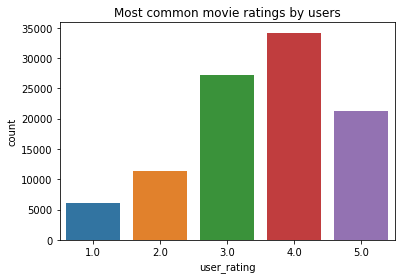

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='user_rating', data=df)
plt.title('Most common movie ratings by users')
plt.show()

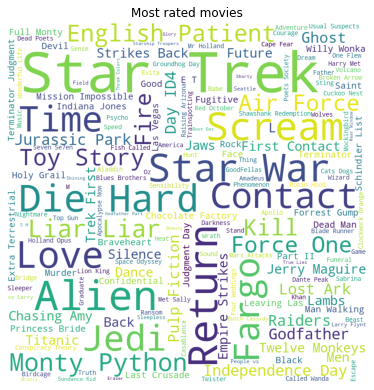

In [37]:
from wordcloud import WordCloud, STOPWORDS

titles = df['movie_title'].tolist() # convert to list of movie title strings

stopwords = STOPWORDS # filter common filler words in movie titles
wordcloud = WordCloud(width=800, height=800, stopwords=stopwords, background_color="white", min_font_size=10).generate(' '.join(titles))

plt.figure(figsize=(5, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Most rated movies')
plt.show()

# Movie Ranking Predictor Model

### Split into training and testing

In [11]:
# Set random seed for repeatability
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

# 80-20 split in training and testing data 
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

Create a map of unique movie titles and user IDs

In [13]:
movie_titles = ratings.batch(100_000).map(lambda x: x["movie_title"])
user_ids = ratings.batch(100_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

### Tensorflow ranking model

In [14]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users
    self.user_embeddings = tf.keras.Sequential([
      # convert user IDs to embeddings
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      # embed user IDs
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies
    self.movie_embeddings = tf.keras.Sequential([
      # convert movie titles to embeddings
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      # embed movie titles
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions
    self.ratings = tf.keras.Sequential([
      # learn multiple dense layers
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # make rating predictions in the final layer
      tf.keras.layers.Dense(1)
  ])
  
  # Process inputs and return final output
  def call(self, inputs):

    user_id, movie_title = inputs

    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_title)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

### Loss and metrics

Loss - Mean Absolute Error (MAE): 
measures the average magnitude of the errors between the predicted and true ratings. 

Metrics - Mean Absolute Percentage Error (MAPE):
measures the mean percentage error of the predictions. 

In [15]:
# Create ranking task with MAE loss and MAPE metrics
task = tfrs.tasks.Ranking(loss=tf.keras.losses.MeanAbsoluteError(),
                          metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

### Movie Predictor Model

In [16]:
class MoviePredictorModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()

    # Create an instance of the TF ranking model
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanAbsoluteError(),
      metrics=[tf.keras.metrics.MeanAbsolutePercentageError()]
    )

  # Function to call the ranking_model on the input features "user_id" and "movie_title"
  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["movie_title"]))

  # Function to compute loss and metrics
  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # remove the label "user_rating" from features
    labels = features.pop("user_rating")
    
    # get the rating predictions from the call function
    rating_predictions = self(features)

    return self.task(labels=labels, predictions=rating_predictions)

# Model fitting and evaluation

In [17]:
# Shuffle, batch, and cache training and testing data
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

Implement early stopping to stop training once the model performance stops improving.

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

model = MoviePredictorModel()
# Define early stopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=30)

In [47]:
# Compile model with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

# Run the MoviePredictorModel
history = model.fit(
    cached_train,
    validation_data=cached_test,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
10/10 [==============================] - 2s 60ms/step - mean_absolute_percentage_error: 63.2976 - loss: 1.9246 - regularization_loss: 0.0000e+00 - total_loss: 1.9246 - val_mean_absolute_percentage_error: 39.1928 - val_loss: 1.3923 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3923
Epoch 2/50
10/10 [==============================] - 0s 47ms/step - mean_absolute_percentage_error: 36.9535 - loss: 0.9834 - regularization_loss: 0.0000e+00 - total_loss: 0.9834 - val_mean_absolute_percentage_error: 29.7601 - val_loss: 0.8716 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.8716
Epoch 3/50
10/10 [==============================] - 0s 48ms/step - mean_absolute_percentage_error: 31.0261 - loss: 0.8149 - regularization_loss: 0.0000e+00 - total_loss: 0.8149 - val_mean_absolute_percentage_error: 29.8511 - val_loss: 0.7469 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.7469
Epoch 4/50
10/10 [==============================] - 0s 49ms/step - mean_absolute_perc

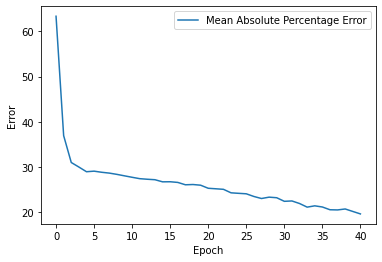

In [48]:
# Plot the mean absolute percentage error and total loss
plt.plot(history.history['mean_absolute_percentage_error'], label='Mean Absolute Percentage Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

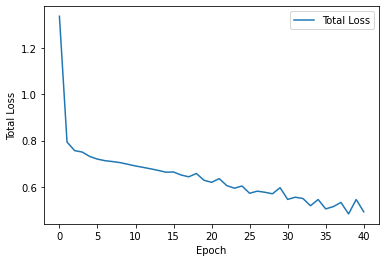

In [49]:
# Plot the mean absolute percentage error and total loss
plt.plot(history.history['loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.legend()
plt.show()

In [50]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 0s 9ms/step - mean_absolute_percentage_error: 33.3726 - loss: 0.8223 - regularization_loss: 0.0000e+00 - total_loss: 0.8223


{'mean_absolute_percentage_error': 33.37262725830078,
 'loss': 0.836696207523346,
 'regularization_loss': 0,
 'total_loss': 0.836696207523346}

# Model testing

In [59]:
# Show a random list of movies rated by user 33
user_id = df[df['user_id'] == 33]
user_random_movies = user_id.sample(n=min(10, len(user_id)), random_state=5)
print(user_random_movies)

                                  movie_title  user_id  user_rating
85650                     Dante's Peak (1997)       33          4.0
3511                         Liar Liar (1997)       33          3.0
75515                 Devil's Own, The (1997)       33          3.0
81744                         Mad City (1997)       33          3.0
84498                        Game, The (1997)       33          4.0
90376                Conspiracy Theory (1997)       33          4.0
56824                        Soul Food (1997)       33          3.0
41916                          Contact (1997)       33          4.0
9730               Tomorrow Never Dies (1997)       33          4.0
2992   I Know What You Did Last Summer (1997)       33          4.0


### Save and interact with the model 

In [60]:
tf.saved_model.save(model, "MovieRankingModel")

In [61]:
MovieRankingsPredict = tf.saved_model.load("MovieRankingModel")

In [62]:
# extract movie titles from the dataset
movies = ratings.map(lambda x: x["movie_title"])
movies = set([str(x.numpy().decode()) for x in movies])

In [64]:
import random

user_pred = input("Enter your user id: ")

generate_movies = input("Generate a list of movies to try? (Y/N): ")
if (generate_movies == "y"):
  # generate list of random movie titles
  random_movies = random.sample(movies, 5)
  # output 5 random movies
  print(f"\nPick one movie to rank:")
  for movie in random_movies:
    print("- " + movie)

movie_title_pred = input(f"\nEnter the movie to predict ratings for: ")

result = MovieRankingsPredict({"user_id": np.array([user_pred]), "movie_title": [movie_title_pred]})
print(f"User " + user_pred + "'s predicted rating for '" + movie_title_pred + "': ")
result.numpy()[0][0]

Enter your user id: 645
Generate a list of movies to try? (Y/N): y

Pick one movie to rank:
- Terminal Velocity (1994)
- Power 98 (1995)
- Of Love and Shadows (1994)
- One Night Stand (1997)
- Getting Even with Dad (1994)

Enter the movie to predict ratings for: Terminal Velocity (1994)
User 645's predicted rating for 'Terminal Velocity (1994)': 


3.2024999